In [20]:
#basic RNN
import tensorflow as tf

n_inputs =3
n_neurons = 5

X0 =  tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons], dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons, n_neurons], dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) +b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

In [21]:
import numpy as np

X0_batch = np.array([[0,1,2], [3,4,5], [6,7,8], [9,0,1]])
X1_batch = np.array([[9,8,7],[0,0,0],[6,5,4],[3,2,1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0:X0_batch, X1:X1_batch})
    

In [22]:
print(Y0_val)

[[ 0.736362    0.56424904 -0.9928428   0.99697137  0.9957681 ]
 [ 0.9999985   0.98514026 -1.          1.          1.        ]
 [ 1.          0.9995978  -1.          1.          1.        ]
 [ 0.99999887  0.9990503  -0.99999994  0.99999994  0.99580586]]


In [23]:
print(Y1_val)

[[ 1.          0.9999874  -1.          1.          1.        ]
 [ 0.69753206  0.6118082  -0.90616906  0.9795825  -0.8114883 ]
 [ 1.          0.9986853  -1.          1.          1.        ]
 [ 0.9999879   0.9524181  -0.99999994  0.99996644  0.9973081 ]]


## BasicRNNCell

In [24]:
tf.reset_default_graph()
# static unrolling through time

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])
# we create input palceholders

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
#  we create BasicRNNCell which you can think of as a factory that creates copies of the cell to build the unrolled RNN

output_seqs,states = tf.contrib.rnn.static_rnn(
                     basic_cell, [X0, X1], dtype=tf.float32)
# we call static rnn which calls the BasicRNNCell creating two copies of cell


Y0, Y1 = output_seqs

In [25]:
# if there wer 50 time steps, it wouldnot be ery convenient to have ot 
# define 50 input placeholders and 50 output tensors

print(Y0)
print(Y1)



Tensor("rnn/basic_rnn_cell/Tanh:0", shape=(?, 5), dtype=float32)
Tensor("rnn/basic_rnn_cell/Tanh_1:0", shape=(?, 5), dtype=float32)


In [26]:
# using the packing sequences
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0:X0_batch, X1:X1_batch})

In [27]:
Y0_val

array([[-0.6220045 ,  0.3434742 ,  0.5967921 ,  0.5467581 , -0.11334981],
       [-0.8740386 ,  0.9972768 ,  0.987609  ,  0.9661833 , -0.81035984],
       [-0.96196574,  0.9999924 ,  0.9996922 ,  0.99798304, -0.972817  ],
       [-0.27229077,  0.9997892 ,  0.99158883,  0.99976593, -0.99935156]],
      dtype=float32)

In [28]:
Y1_val

array([[-0.62965757,  0.99999994,  0.9999669 ,  0.9991317 , -0.9964192 ],
       [ 0.6258266 ,  0.7319028 ,  0.891579  , -0.2367793 , -0.00984494],
       [ 0.22992855,  0.99999607,  0.9997939 ,  0.9622914 , -0.95374256],
       [ 0.55169165,  0.9969307 ,  0.97981477,  0.08551132, -0.7642403 ]],
      dtype=float32)

In [30]:
# from tensorflow_graph_in_jupyter import show_graph

# show_graph(tf.get_default_graph())

## Packing Sequences

In [31]:
# the following cide builds the same RNN again but thistime it takes asingle input 
# placeholder of hsape [None, n_steps, n_inputs ] where the first  fimensions is the mini batch size\
# Then it extract thelist of input sequences for each time step
# X_seqs is a Python list of n_steps tensors of shape [None,n_inputs]
# where once again the first dimension is the mini batch size
# To do this, we first swap using transpose function so that the time steps are now the first dimension 
# then we use the unstack function. The next twolines are the sam
# finally we merge the the output tensors into a single tensor using stack() function
# and we sqap the first two fimension to get a final outputs tensor
# of shape [None, n_steps, n_neurons]

n_steps =2
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps,n_inputs])
X_seqs = tf.unstack(tf.transpose(X,perm=[1,0,2]))
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs, dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1,0,2])

In [32]:
init = tf.global_variables_initializer()

In [34]:
X_batch= np.array([
    [[0,1,2], [9,8,7]],
    [[3,4,5], [0,0,0]],
    [[6,7,8], [6,5,4]],
    [[9,0,1], [3,2,1]]
])
g = tf.Graph()
with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X:X_batch})

# this stillgets one graph containing unit cell per time step
# If there were 50 time steps the graph would look pretty ugly
print(outputs_val)

# with large graph we will also get out of memory errors so that it can
# use them to compute gradients during the reverse pass
# thats why we using dynamic rnn

[[[ 0.80800104 -0.25818652  0.88132834  0.79292494 -0.08273872]
  [-0.5822327  -0.9999026   0.999995   -0.657447   -0.96924794]]

 [[ 0.8161503  -0.9309901   0.99883807  0.84217244 -0.7897056 ]
  [ 0.5496408  -0.85100687  0.21461645 -0.20366207  0.8525351 ]]

 [[ 0.82398736 -0.9956768   0.9999893   0.88048846 -0.9679276 ]
  [-0.33215857 -0.999035    0.9979041  -0.7774459  -0.4956271 ]]

 [[-0.9999593  -0.999779    0.14563009 -0.9997508  -0.93437034]
  [-0.87933636 -0.6990654  -0.65328014 -0.6297835  -0.6142405 ]]]


In [35]:
print(np.transpose(outputs_val, axes=[1,0,2])[1])

[[-0.5822327  -0.9999026   0.999995   -0.657447   -0.96924794]
 [ 0.5496408  -0.85100687  0.21461645 -0.20366207  0.8525351 ]
 [-0.33215857 -0.999035    0.9979041  -0.7774459  -0.4956271 ]
 [-0.87933636 -0.6990654  -0.65328014 -0.6297835  -0.6142405 ]]


In [2]:
import tensorflow as tf
tf.reset_default_graph()

n_steps =2
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

W0616 10:20:31.411031 12108 deprecation.py:323] From <ipython-input-2-6755c56d7f85>:10: BasicRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
W0616 10:20:31.414023 12108 deprecation.py:323] From <ipython-input-2-6755c56d7f85>:11: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
W0616 10:20:31.476860 12108 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\python\ops\rnn_cell_impl.py:456: Layer.add_variable (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.add_weight` method instead.
W0616 10:20:31.487831 121

In [3]:
init = tf.global_variables_initializer()

In [6]:
import numpy as np
X_batch =  np.array([
    [[0,1,2], [9,8,7]],
    [[3,4,5], [0,0,0]],
    [[6,7,8], [6,5,4]],
    [[9,0,1], [3,2,1]]
])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X:X_batch})

In [8]:
print(outputs_val)

# show_graph(tf.get_default_graph())

[[[-0.3075267   0.5299915   0.16965647  0.87184805  0.58252114]
  [-0.9981262   0.9964085  -0.09262892 -0.39578518  0.97315013]]

 [[-0.9239652   0.97164756  0.09598505  0.93754584  0.9429492 ]
  [ 0.47932312 -0.8938842   0.2604586  -0.45113435 -0.44469807]]

 [[-0.9941193   0.9986546   0.02124681  0.97010124  0.9934848 ]
  [-0.93894494  0.74343777 -0.0715929  -0.8035607   0.7878499 ]]

 [[-0.99964064  0.9620414  -0.99611646 -0.9999498  -0.9915379 ]
  [-0.41506955  0.73790824 -0.7738236  -0.97888213  0.9177495 ]]]


## Setting the sequence lengths

In [9]:
n_steps = 2
n_inputs = 3
n_neurons = 5

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)


In [10]:
seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)

W0616 10:26:55.937911 12108 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\python\ops\rnn.py:244: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
init = tf.global_variables_initializer()

In [13]:
X_batch = np.array([
    #step 0   step 1
    [[0,1,2], [9,8,7]], # instance 1
    [[3,4,5], [0,0,0]], # Padded Instance 2
    [[6,7,8], [6,5,4]], # instance 3
    [[9,0,1], [3,2,1]],  # instance 4
])

seq_length_batch = np.array([2,1,2,2])

In [15]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states],feed_dict={X:X_batch, seq_length: seq_length_batch })
    

In [16]:
print(outputs_val)

[[[-0.11812522 -0.20228527  0.11452613  0.11399005  0.3338867 ]
  [-0.99728656 -0.9996351   0.75922894 -0.99910766  0.24618293]]

 [[-0.87457997 -0.94072527  0.44783533 -0.8127231   0.474531  ]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.9887129  -0.997192    0.69051933 -0.98316467  0.5945068 ]
  [-0.96373564 -0.9832916   0.7888061  -0.96899116 -0.5954966 ]]

 [[-0.9998727  -0.9999861  -0.9860169  -0.9999886  -0.65876055]
  [-0.8518146  -0.9395353   0.88231933 -0.6496556  -0.8854977 ]]]


In [17]:
print(states_val)

[[-0.99728656 -0.9996351   0.75922894 -0.99910766  0.24618293]
 [-0.87457997 -0.94072527  0.44783533 -0.8127231   0.474531  ]
 [-0.96373564 -0.9832916   0.7888061  -0.96899116 -0.5954966 ]
 [-0.8518146  -0.9395353   0.88231933 -0.6496556  -0.8854977 ]]


## Training a sequence classifier

In [20]:
tf.reset_default_graph()

n_steps =28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

# these are the two lines that are defining a RNN
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X # from feed_dict
                                    ,dtype=tf.float32)

# dynamic and static rnn bothe functions calls the BasicRNNCell call function per input
# createing two copise with n_neurons no. of connection between the layers
# it returns twoobjects  python list containing the output tensors foreach step and final states of the network
#in basic cell the final state is equal to the last output

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y  # from feed_dict
                                                          , logits=logits)

loss= tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [22]:
(X_train,y_train), (X_test,y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28 * 28)/ 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28 * 28)/255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]


In [27]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        # this is a generator
        # multiple returns to single call

In [24]:
X_test = X_test.reshape((-1, n_steps,n_inputs))

In [28]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps,n_inputs ))
            sess.run(training_op,feed_dict={X:X_batch,y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
        acc_test = accuracy.eval(feed_dict={X:X_test, y:y_test})
        print(epoch,"Last batch accuracy: ", acc_batch, "Test accuracy:", acc_test)

0 Last batch accuracy:  0.9266667 Test accuracy: 0.9357
1 Last batch accuracy:  0.98 Test accuracy: 0.9441
2 Last batch accuracy:  0.97333336 Test accuracy: 0.9637
3 Last batch accuracy:  0.9533333 Test accuracy: 0.9549
4 Last batch accuracy:  0.97333336 Test accuracy: 0.9657
5 Last batch accuracy:  0.98 Test accuracy: 0.9636
6 Last batch accuracy:  0.94666666 Test accuracy: 0.9664
7 Last batch accuracy:  0.98 Test accuracy: 0.9691
8 Last batch accuracy:  0.97333336 Test accuracy: 0.9743
9 Last batch accuracy:  0.98 Test accuracy: 0.9733
10 Last batch accuracy:  0.96666664 Test accuracy: 0.965
11 Last batch accuracy:  0.97333336 Test accuracy: 0.9682
12 Last batch accuracy:  0.96666664 Test accuracy: 0.9716
13 Last batch accuracy:  0.98 Test accuracy: 0.9656
14 Last batch accuracy:  0.9866667 Test accuracy: 0.9715
15 Last batch accuracy:  0.9866667 Test accuracy: 0.9696
16 Last batch accuracy:  0.9866667 Test accuracy: 0.9743
17 Last batch accuracy:  0.98 Test accuracy: 0.9742
18 Last 

### Multi Layer RNN

In [30]:
# multi layer RNN

tf.reset_default_graph()

n_steps = 28
n_inputs = 28
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None,n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

In [31]:
n_neurons = 100
n_layers = 2

layers = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)for layer in range(n_layers)]
# layers is not required here

multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

W0616 11:33:53.245198 12108 deprecation.py:323] From <ipython-input-31-766197b0afd1>:7: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


In [32]:
states_concat = tf.concat(axis=1, values=states)

logits = tf.layers.dense(states_concat,n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [33]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1,n_steps,n_inputs ))
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        acc_batch = accuracy.eval(feed_dict={X:X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X:X_test, y: y_test})
        print(epoch, "last batch accuracy: ", acc_batch, "test_accuracy: ", acc_test)

0 last batch accuracy:  0.93333334 test_accuracy:  0.9233
1 last batch accuracy:  0.97333336 test_accuracy:  0.9529
2 last batch accuracy:  0.94 test_accuracy:  0.9631
3 last batch accuracy:  0.98 test_accuracy:  0.9662
4 last batch accuracy:  0.97333336 test_accuracy:  0.9651
5 last batch accuracy:  0.9866667 test_accuracy:  0.9756
6 last batch accuracy:  0.96666664 test_accuracy:  0.9717
7 last batch accuracy:  0.97333336 test_accuracy:  0.9719
8 last batch accuracy:  0.9866667 test_accuracy:  0.9744
9 last batch accuracy:  0.98 test_accuracy:  0.9779


### Predicting time series

In [37]:
# creating a RNN ,of 100recurrent neurons 
# we willunrollover 20 time steps since
# the traininginstance will be 20 inputs long
# each input will contain only one feature (the value at that time)
# the targets are also seuquences of 20 inputs each containing a single value

t_min, t_max = 0,30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 * 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size,1) * (t_max - t_min - n_steps * resolution)
    # print("to: ",t0)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    # print("ts: ",Ts)
    ys = time_series(Ts)
    # print("ys: ",ys)
    return ys[:,:-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

In [31]:
print(time_series(1))

-0.537937969171326


In [36]:
print(next_batch(1, 5))

to:  [[10.15263574]]
ts:  [[10.15263574 10.25263574 10.35263574 10.45263574 10.55263574 10.65263574]]
ys:  [[-2.14966789 -4.22963268 -5.50898266 -5.43086842 -3.81571591 -0.95909383]]
(array([[[-2.14966789],
        [-4.22963268],
        [-5.50898266],
        [-5.43086842],
        [-3.81571591]]]), array([[[-4.22963268],
        [-5.50898266],
        [-5.43086842],
        [-3.81571591],
        [-0.95909383]]]))



 [12.2   12.305 12.41  12.515 12.62  12.725 12.83  12.935 13.04  13.145
 13.25  13.355 13.46  13.565 13.67  13.775 13.88  13.985 14.09  14.195
 14.3  ]


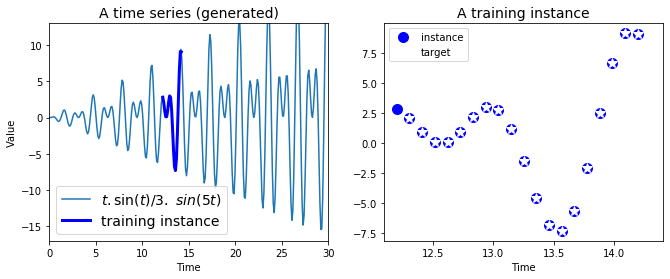

In [39]:
import matplotlib.pyplot as plt
import numpy as np

t = np.linspace(t_min, t_max,int((t_max - t_min)/resolution))
#print(t)

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1 )
print("\n", t_instance)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t,time_series(t), label=r"$t . \sin(t) / 3 . \ sin(5t)$")
plt.plot(t_instance[:-1],time_series(t_instance[:-1]), "b-", linewidth=3,label="training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10,label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

In [5]:
X_batch, y_batch =next_batch(1, n_steps)

In [6]:
np.c_[X_batch[0], y_batch[0]]

array([[ -9.39223279, -10.79614856],
       [-10.79614856,  -9.36385209],
       [ -9.36385209,  -5.16508802],
       [ -5.16508802,   0.84719113],
       [  0.84719113,   7.08519637],
       [  7.08519637,  11.79755521],
       [ 11.79755521,  13.61280226],
       [ 13.61280226,  11.97610629],
       [ 11.97610629,   7.33269926],
       [  7.33269926,   0.99445678],
       [  0.99445678,  -5.26837189],
       [ -5.26837189,  -9.77623209],
       [ -9.77623209, -11.44921479],
       [-11.44921479, -10.10957841],
       [-10.10957841,  -6.48268681],
       [ -6.48268681,  -1.90440234],
       [ -1.90440234,   2.15747788],
       [  2.15747788,   4.59869942],
       [  4.59869942,   5.01972671],
       [  5.01972671,   3.79898732]])

In [8]:
# using an OutputProjectionWrapper
import tensorflow as tf
tf.reset_default_graph()

n_steps= 20
# what are steps 

n_inputs = 1
n_neurons = 100
# what are neurons

n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32,[None,n_steps,n_outputs])

cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)


W0618 09:57:12.701964 12748 deprecation.py:323] From <ipython-input-8-db3a5237284c>:13: BasicRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
W0618 09:57:12.703960 12748 deprecation.py:323] From <ipython-input-8-db3a5237284c>:14: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
W0618 09:57:12.846168 12748 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\python\ops\rnn_cell_impl.py:456: Layer.add_variable (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.add_weight` method instead.
W0618 09:57:12.857134 127

In [9]:
# howeverwhat we want is a signle output value at each step
# right now we have 100 output vectors
# in the code above

tf.reset_default_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs ])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])


In [11]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),output_size=n_outputs)

In [12]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

W0618 10:03:10.921170 12748 deprecation.py:506] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\contrib\rnn\python\ops\core_rnn_cell.py:104: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [13]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [14]:
saver = tf.train.Saver()

In [15]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size,n_steps )
        sess.run(training_op, feed_dict={X:X_batch,y:y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y:y_batch})
            print(iteration, "\tMSE:", mse)
        saver.save(sess, "./my_time_series_model")

0 	MSE: 24.476606
100 	MSE: 1.4968365
200 	MSE: 0.691253
300 	MSE: 0.6037233
400 	MSE: 0.5793171
500 	MSE: 0.5706452
600 	MSE: 0.42727375
700 	MSE: 0.48870742
800 	MSE: 0.48185402
900 	MSE: 0.3630353
1000 	MSE: 0.3921422
1100 	MSE: 0.39920416
1200 	MSE: 0.3337824
1300 	MSE: 0.4242592
1400 	MSE: 0.3992935


In [16]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

In [17]:
y_pred

array([[[ 2.5749042 ],
        [ 0.7054816 ],
        [-0.36172363],
        [-0.18785259],
        [ 0.9394613 ],
        [ 2.2135847 ],
        [ 3.1755395 ],
        [ 2.9489105 ],
        [ 1.2200302 ],
        [-1.5164654 ],
        [-4.740799  ],
        [-6.913212  ],
        [-7.4023304 ],
        [-5.8214974 ],
        [-2.2746859 ],
        [ 2.526572  ],
        [ 6.846301  ],
        [ 9.405141  ],
        [ 9.217132  ],
        [ 6.5340533 ]]], dtype=float32)

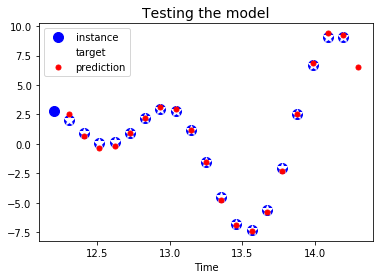

In [18]:
plt.title("Testing the model", fontsize =14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0, :, 0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

### without using outputprojectionwrapper

In [19]:
tf.reset_default_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps,n_inputs])
y = tf.placeholder(tf.float32, [None,n_steps,n_outputs])


In [20]:
cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons,activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

In [21]:
n_outputs = 1
learning_rate = 0.001

In [23]:
# here we are using a dense laer to give us a single output

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1,n_neurons ])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps,n_outputs])

W0618 10:23:33.135255 12748 deprecation.py:323] From <ipython-input-23-cd7925fad3ed>:2: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.Dense instead.
W0618 10:23:33.135873 12748 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\python\layers\core.py:187: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.


In [24]:
loss = tf.reduce_mean(tf.square(outputs-y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [27]:
n_iteration = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size,n_steps )
        sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        if (iteration % 100 == 0):
            mse = loss.eval(feed_dict={X:X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
        
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X:X_new})
    
    saver.save(sess, "./my_time_series_model")
    

0 	MSE: 34.098057
100 	MSE: 1.1983507
200 	MSE: 1.0681823
300 	MSE: 0.4967683
400 	MSE: 0.32249728
500 	MSE: 0.37619054
600 	MSE: 0.39132816
700 	MSE: 0.511668
800 	MSE: 0.34348136
900 	MSE: 0.3476996
1000 	MSE: 0.5621788
1100 	MSE: 0.5280415
1200 	MSE: 0.32791147
1300 	MSE: 0.38845745
1400 	MSE: 0.44612303


In [28]:
y_pred

array([[[ 2.7105174 ],
        [ 0.6668517 ],
        [-0.29246297],
        [-0.14830099],
        [ 0.76858336],
        [ 2.3107    ],
        [ 3.1291492 ],
        [ 2.839957  ],
        [ 1.153141  ],
        [-1.4780499 ],
        [-4.6290593 ],
        [-6.9487834 ],
        [-7.4354606 ],
        [-5.70628   ],
        [-2.0034468 ],
        [ 2.6026359 ],
        [ 6.7267227 ],
        [ 9.158411  ],
        [ 9.129086  ],
        [ 6.4726453 ]]], dtype=float32)

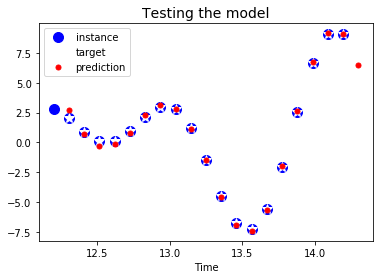

In [30]:
plt.title("Testing the model", fontsize =14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:],y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

### generating a creative sequence

In [42]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")
    
    sequence = [0.] * n_steps
    for iteration in range (300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred =sess.run(outputs, feed_dict={X:X_batch})
        sequence.append(y_pred[0,-1,0])

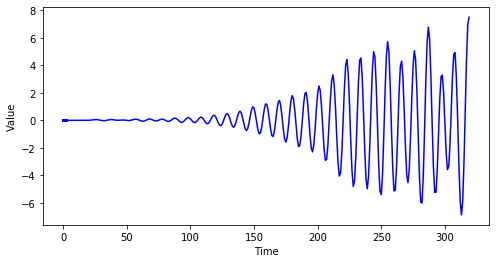

In [44]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

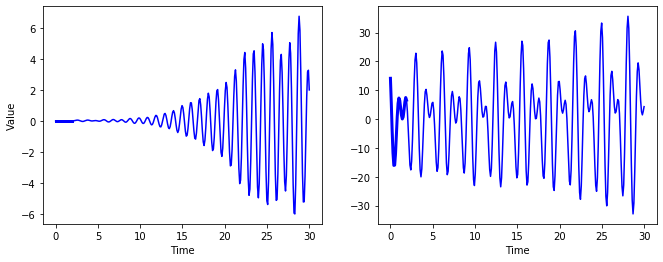

In [48]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")
    
    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1,n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch })
        sequence1.append(y_pred[0,-1,0])
    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch =np.array(sequence2[-n_steps:]).reshape(1,n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X:X_batch})
        sequence2.append(y_pred[0,-1,0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-",linewidth=3 )
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.show()